# <center>Домашнее задание по занятию 22
# <center>GANs
## 1. Сделать сверточный GANs

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [8]:
lr = 0.001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh, 
                                                path='./../MNIST_data')
fixed_z = torch.randn((50, 1, 28, 28))

In [6]:
# class FullyConnected(nn.Module):
#     def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
#         super(FullyConnected, self).__init__()
#         layers = []
#         self.flatten = flatten
#         for i in range(len(sizes) - 2):
#             layers.append(nn.Linear(sizes[i], sizes[i+1]))
#             if dropoutut:
#                 layers.append(nn.Dropout(dropout))
#             layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
#         else: 
#             layers.append(nn.Linear(sizes[-2], sizes[-1]))
#         if last_fn is not None:
#             layers.append(last_fn)
#         self.model = nn.Sequential(*layers)
        
#     def forward(self, x):
#         if self.flatten:
#             x = x.view(x.shape[0], -1)
#         return self.model(x)

In [7]:
class ConvGan(nn.Module):
    def __init__(self, channels, dropout=False, activation_fn=nn.Tanh(), binar_class=False, last_fn=None):
        super().__init__()
        layers = []
        self.last_fn = last_fn
        self.binar_class = binar_class
        for i in range(len(channels) - 2):
            layers.append(nn.Conv2d(channels[i], channels[i+1], kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(channels[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и функция активации в последнем слое
        
        else: 
            layers.append(nn.Conv2d(channels[-2], channels[-1], kernel_size=3, padding=1))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.model(x)
        if self.binar_class:
            x = x.view(x.shape[0], -1)
            x = nn.Linear(x.shape[1], 1)(x)
            x = torch.sigmoid(x)
        if self.last_fn is not None:
            x = self.last_fn(x)
        return x

In [9]:
G = ConvGan([1, 6, 6, 6, 1], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = ConvGan([1, 6, 6, 6, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), binar_class=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [10]:
# G = FullyConnected([prior_size, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
# D = FullyConnected([28*28, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

# G_optimizer = optim.Adam(G.parameters(), lr=lr)
# D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [11]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [12]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [13]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, 1, 28, 28))
        fake_pred = D(G(z))
        true_pred = D(data)
        
        fake_loss = F.binary_cross_entropy(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, 1, 28, 28))
        fake_pred = D(G(z))
        G_loss = F.binary_cross_entropy(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [14]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, _ in loader:
            z = torch.randn((batch_size, 1, 28, 28))
            fake_pred = D(G(z))
            true_pred = D(data)
        
            fake_loss = F.binary_cross_entropy(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z).data.numpy()
    
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.6867, D: 0.6463
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 0.6421, D: 0.6647
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 0.6767, D: 0.6874


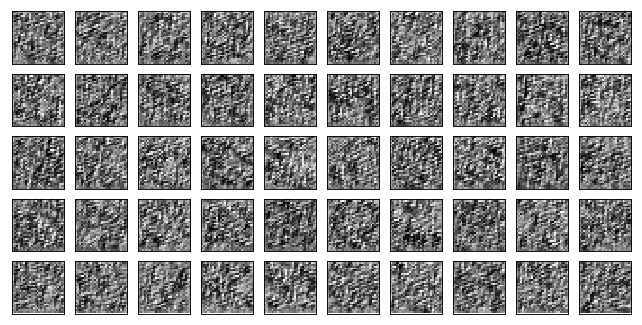

Test losses. G: 0.6935, D: 0.6957
Train Epoch: 2 [0/50000 (0%)]	Losses G: 0.7289, D: 0.7155


KeyboardInterrupt: 

In [15]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)